# **Project 3 - Reinforcement Learning**


## 🌞 Mission: Find a secret Location in Trondheim where SkyNets servers are located


📊 **High-level goal:**

Train an agent (the “learner”) to interact with given environment and learn from it, so it can maximize its cumulative rewards over time.

- **Environment:**
  _ The environment **is already created** and set up for you with the help of
  "gym" library.
  _ The agent is interacting with a simulated environment, which has states, accepts actions, and returns rewards. The environment resets at the beginning of each episode, and the agent takes actions within it, receiving feedback in the form of rewards.
- **Q-table:**
  - This table stores information about the "quality" of actions in different states.
  - The goal of the agent is to update the Q-table over time to estimate the value of taking different actions in various states.
  - You will initialize and learn Q-table in this project.


## 📮 Imports:


In [1]:
import os
from typing import Any

import imageio.v3 as iio
import numpy as np
from gym import Env
from gym.spaces import Discrete, MultiDiscrete
from matplotlib import pyplot as plt
from matplotlib.animation import ArtistAnimation
from matplotlib.image import AxesImage
from numpy import floating
from numpy.typing import NDArray

In [2]:
SEED = 69_420
rng = np.random.default_rng(SEED)

In [3]:
def get_path(folder: str, image: str = "") -> str:
    return os.path.join(folder, image)

### Utility functions are provided for you:

- one_hot_decode
- one_hot_encode
- make_2d
- make_3d
- read_png_file
- is_valid_idx
- flatten_observation
- is_valid_idx
- flatten_observation
- make_2d_observation
- swap_values


In [4]:
def one_hot_decode(label_3D: NDArray[Any]) -> NDArray[Any]:
    """Converts back from one-hot encoded format (label_3D) to original
    class labels for each pixel (2D).
    """
    return np.argmax(label_3D, axis=-1)


def one_hot_encode(
    label_2D: NDArray[Any], label_values: NDArray[Any]
) -> NDArray[Any]:
    """Converts a segmentation image label array (label_2D) to one-hot
    formatby replacing each pixel value with a vector of length
    num_classes.

    # Arguments
        label_2D: The 2D array segmentation image label.
        label_values: an RGB array of classes (num_classes, 3).

    # Returns
        A 3D array with the same width and height as the input, but with
        a depth size of num_classes (for each pixel).

        Each class gets its own encoding for every pixel in the image.
        Encodings are then stacked along new axis which is number of classes.
    """
    semantic_map: list[NDArray[Any]] = []

    for colour in label_values:
        equality = np.equal(label_2D, colour)
        class_map = np.all(equality, axis=-1)
        semantic_map.append(class_map)

    return np.stack(semantic_map, axis=-1)


def make_2d(
    map_3d: NDArray[Any] | None = None,
    palette_array: NDArray[Any] | None = None,
) -> NDArray[Any]:
    """Converts RGB images to images with number of class as value at
    [i,j].

    map_3d: 3D RGB image (H, W, n_ch = 3)
    palette_array: an RGB array of classes (num_classes, 3)

    Result: 2D structure where each "pixel" in the image
    has a class number instead of RGB color
    """
    replaced_image_onehot = one_hot_encode(
        map_3d.astype(np.uint8), palette_array
    )
    return one_hot_decode(replaced_image_onehot)


def make_3d(
    map_2d: NDArray[Any] | None = None,
    palette_array: NDArray[Any] | None = None,
) -> NDArray[Any]:
    """Convert a 2d img to 3d.
    Convert a 2D image where each pixel represents a class label into a
    3D image where each class label is represented by its corresponding
    RGB color from the palette_array.
    Creates colorized 3D image from the original 2D class map

    map_2d: array of class labels, size (H, W)
    palette_array: an RGB array of classes (num_classes, 3)

    Result: RGB image (H, W, 3)
    """
    return palette_array[map_2d.astype(np.uint8)]


def read_png_file(image_path: str, printDebug: bool = True) -> NDArray[Any]:
    """Read a png file and returns it as a 3D numpy array."""
    original_image_matrix = iio.imread(image_path)

    if original_image_matrix.ndim <= 2 or original_image_matrix.shape[-1] <= 3:
        return original_image_matrix
    if printDebug:
        print(
            f"image has more than 3 channels, only first 3 channels are used "
            f"there are {original_image_matrix.shape} channels"
        )

    return original_image_matrix[:, :, :3]


def is_valid_idx(image_2D, selected_idx: tuple[int, int]) -> bool:
    """Checks if a given index is within the valid range of a 2D array.

    if selected_idx is valid in image_2D
    selected_idx = [i,j]
    image_2D = [h,w]
    """
    if selected_idx[0] < 0 or selected_idx[1] < 0:
        return False
    if (
        selected_idx[0] < image_2D.shape[0]
        and selected_idx[1] < image_2D.shape[1]
    ):
        return True
    return False


def flatten_observation(observation_arr: NDArray[Any]) -> NDArray[Any]:
    """Converts/flattens a multi-dimensional array into a 1D array."""
    return observation_arr.flatten


def make_2d_observation(
    observation_flattened: NDArray[Any], observation_arr_shape: NDArray[Any]
) -> NDArray[Any]:
    """Converts flattened array into shape observation_arr_shape."""
    return observation_flattened.reshape(observation_arr_shape.shape)


def swap_values(arr: NDArray[Any], value1: int, value2: int) -> NDArray[Any]:
    """Swaps occurencies of two specific values (value1 and value2)
    within a 2D NumPy array (arr).

    arr: A 2D NumPy array where we want to swap the values.
    value1: the first value that we want to swap with value2.
    value2: the second value that we want to swap with value1.

    Returns: 2D array with swapped values.
    """
    value1, value2 = int(value1), int(value2)
    pos_value1 = np.argwhere(arr == value1)

    if pos_value1.size > 0:
        arr[pos_value1[0, 0], pos_value1[0, 1]] = value2

    pos_value2 = np.argwhere(arr == value2)

    if len(pos_value2) <= 1:
        return arr

    pos_value2 = pos_value2[np.all(pos_value2 != pos_value1[0], axis=1)]

    if pos_value2.size > 0:
        random_pos_value2 = pos_value2[np.random.choice(len(pos_value2))]
        arr[random_pos_value2[0], random_pos_value2[1]] = value1

    return arr

### Environment class with necessary functions - provided for you:

- constructor **init**
- step
- reset
- get_1d_state
- render
- close


In [5]:
class TrondheimEnv(Env):
    metadata = {"render.modes": ["human"]}

    def __init__(self, conf: dict[str, Any]) -> None:
        """Every environment should be derived from gym.Env and at least
        contain variables observation_space and action_space specifying
        the type of possible observations and actions using spaces.Box
        or spaces.Discrete.

        Example:
        >>> EnvTest = TrondheimEnv()
        >>> EnvTest.observation_space=spaces.Box(low=-1, high=1, shape=(3,4))
        >>> EnvTest.action_space=spaces.Discrete(2)
        """
        self.manual_mode = True

        number_action = 4
        self.action_space = Discrete(number_action)

        self.env_image_path = conf["env_image_path"]
        self.number_removable_locations = conf["number_removable_locations"]

        self.pallete = np.array(
            [
                [0, 0, 255],  # Blue:0:Water
                [255, 255, 0],  # Yellow:1:Start
                [0, 255, 0],  # Green:2:Land
                [255, 0, 0],  # Red:3:BusLane
                [128, 0, 128],  # Purple:4:BusStop
                [0, 0, 0],  # Black:5:Secret Location
                [128, 128, 0],  # Olive:6:Final Location
            ],
            dtype=np.uint8,
        )

        self.neighbours = np.array(
            [[-1, 0], [0, -1], [1, 0], [0, 1]]
        )  # up, left, down, right
        self.not_allowed_area = [0]  # water
        self.normal_land_class = 2  # land
        self.neutral_area = [self.normal_land_class, 3]  # land and BusLane
        self.start_class = 1  # start
        self.busstop_class = 4  # bus stop
        self.secret_location_class = 5  # secret location
        self.final_location_class = 6  # final location (2)

        self.dead_allowed = conf["dead_allowed"]
        self.remove_after_location_found = conf["remove_after_location_found"]
        self.start_random = conf["start_random"]

        img_3d = read_png_file(self.env_image_path, printDebug=False)
        img_2d = make_2d(map_3d=img_3d, palette_array=self.pallete)
        self.observation = img_2d
        self.initial_observation = img_2d.copy()

        max_observation_value = np.max(img_2d)
        # assert isinstance(max_observation_value, int)
        observation_space = np.full_like(
            img_2d, fill_value=max_observation_value
        )
        self.observation_space = MultiDiscrete(observation_space)
        self.reward = 0
        self.done = False
        self.terminated = False

    def step(self, action: int) -> tuple[NDArray[Any], int, bool, None]:
        """This method is the primary interface between environment and
        agent.

        Parameters:
            action: the index of the respective action (if action space
                    is discrete)

        Returns:
            output: information provided by the environment about its
                    current state: (observation, reward, done)

                    self.observation: The updated state of the environment (2D)
                    reward: Reward agent received for the action in this step (Int)
                    terminated: indicate if the episode has ended (Bool)
                    info: Additional information (not used currently)

        """
        obs = self.observation
        terminated = False
        truncated = False  # not used
        info = None

        start_idx = np.argwhere(obs == self.start_class)[0]
        next_idx = start_idx + self.neighbours[action]
        reward = self.reward

        if self.manual_mode:
            print("Next step towards:")

        if not is_valid_idx(image_2D=obs, selected_idx=next_idx):
            next_idx = start_idx

            if self.manual_mode:
                print(
                    "Hey there, you cannot escape outside of the environment"
                )

        if obs[tuple(next_idx)] == self.normal_land_class:
            if self.manual_mode:
                print("Green Land class area")

        if obs[tuple(next_idx)] in self.not_allowed_area:
            if self.manual_mode:
                print("The move is not allowed")

            if self.dead_allowed:
                reward = -1000
                terminated = True
            else:
                next_idx = start_idx

        elif obs[tuple(next_idx)] == self.busstop_class:
            if self.manual_mode:
                print("A bus stop")

            bus_stop_indices = np.argwhere(obs == self.busstop_class)

            if np.array_equal(next_idx, bus_stop_indices[0]):
                next_idx = bus_stop_indices[1]
            else:
                next_idx = bus_stop_indices[0]

        elif obs[tuple(next_idx)] == self.secret_location_class:
            if self.manual_mode:
                print("Central Source Secret Location")

            reward = 300

            if self.remove_after_location_found:
                self.initial_observation[tuple(next_idx)] = (
                    self.normal_land_class
                )
                self.number_removed_shop += 1
                reward = 9000

        elif obs[tuple(next_idx)] == self.final_location_class:
            if self.manual_mode:
                print("Final Location - well done!")
                print(
                    "You have discovered the Final Location of AI center in "
                    "Trondheim"
                )

            reward = 200

        if self.initial_observation[tuple(start_idx)] == self.start_class:
            self.observation[tuple(start_idx)] = self.normal_land_class
        else:
            self.observation[tuple(start_idx)] = self.initial_observation[
                tuple(start_idx)
            ]

        self.observation[tuple(next_idx)] = self.start_class
        return self.observation, reward, terminated, info

    def reset(self) -> NDArray[Any]:
        """This method resets the environment to its initial values.

        Returns:
            observation: The initial state of the environment.
        """
        self.number_removed_shop = 0

        img_3d = read_png_file(self.env_image_path, printDebug=False)
        img_2d = make_2d(map_3d=img_3d, palette_array=self.pallete)

        if self.start_random:
            img_2d = swap_values(arr=img_2d, value1=1, value2=2)

        self.observation = img_2d
        self.initial_observation = img_2d.copy()

        max_observation_value = np.max(img_2d)
        observation_space = np.full_like(
            img_2d, fill_value=max_observation_value
        )
        self.observation_space = MultiDiscrete(observation_space)

        self.reward = 0
        self.done = False
        self.terminated = False
        return self.observation

    def get_1d_state(self) -> int:
        """This function returns state as 1d observation."""
        max_x, max_y = self.observation.shape

        start_idx = np.argwhere(self.observation == self.start_class)[0]
        state_number = start_idx[0] * max_x + start_idx[1]
        state_number += self.number_removed_shop * max_x * max_y
        return state_number

    def render(
        self, mode: Any = "human", close: Any = False, display: bool = True
    ) -> NDArray[Any]:
        """This methods provides the option to render the environment's
        behavior to a window which should be readable to the human eye
        if mode is set to 'human'.
        """
        render_ready_arr = make_3d(
            map_2d=self.observation, palette_array=self.pallete
        )

        if display:
            plt.imshow(render_ready_arr)
            plt.show()
            plt.close()

        return render_ready_arr

    def close(self) -> None:
        """This method provides the user with the option to perform
        necessary cleanup.
        """
        img_3d = read_png_file(self.env_image_path)
        img_2d = make_2d(map_3d=img_3d, palette_array=self.pallete)
        self.observation = img_2d
        self.initial_observation = img_2d.copy()

In [6]:
input_folder = get_path("input_images")

if not os.path.exists(input_folder):
    os.makedirs(input_folder)

# Configuring and loading the environment:


## 🔎📉 Let's first visualize our simple toy environment


In [7]:
env_config = {
    "env_image_path": get_path(input_folder, "image_simple_1.png"),
    "dead_allowed": False,
    "remove_after_location_found": False,
    "start_random": False,
    "number_removable_locations": 0,
}


if not os.path.exists(env_config["env_image_path"]):
    raise FileNotFoundError(
        f"The image path {env_config['env_image_path']} does not exist."
    )

tmp_env = TrondheimEnv(conf=env_config)
print(f"Environment successfully created")

Environment successfully created


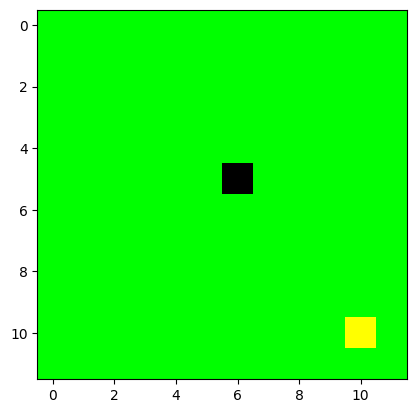

array([[[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]],

       [[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]],

       [[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]],

       [[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255, 

In [8]:
tmp_env.reset()
tmp_env.render()

Let's see how actions work:


In [9]:
action_dict = {
    "up": 0,
    "left": 1,
    "down": 2,
    "right": 3,
}

Next step towards:
Green Land class area
Reward for action left is: 0


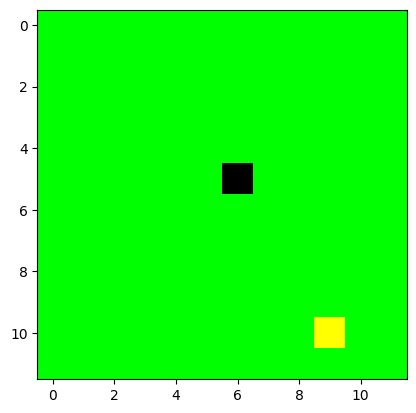

Observation space looks like this:
[[2 2 2 2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 5 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2 1 2 2]
 [2 2 2 2 2 2 2 2 2 2 2 2]]


In [10]:
my_action = "left"
obs, rew, term, info = tmp_env.step(action_dict[my_action])
print(f"Reward for action {my_action} is: {rew}")
tmp_env.render()

print("Observation space looks like this:")
print(obs)

# 🧠 **Your Assignments**


# 1️⃣ Assignment 1: Q-learning with simple toy environment


## 🐣 Let's learn how to do this in a simple environment

- Task 1: Initialize Q table
- Task 2: Write necessary helper functions for Q-learning
- Task 3: Play with Hyperparameters
- Task 4: Train the agent using Q-learning
- Task 5: Explain visual representation of environment after training

**Note**: Task 2, Task 3 and Task 4: you will use the same code you implemented for these in the Assignment 2.


In [11]:
env_config = {
    "env_image_path": get_path(input_folder, "image_simple_1.png"),
    "dead_allowed": False,
    "remove_after_location_found": False,
    "start_random": False,
    "number_removable_locations": 0,
}

if not os.path.exists(env_config["env_image_path"]):
    raise FileNotFoundError(
        f"The image path {env_config['env_image_path']} does not exist."
    )

tmp_env = TrondheimEnv(conf=env_config)
print(f"Environment successfully created")

Environment successfully created


### Task 1: Initialize Q table


In [12]:
# Task 1: Initialize Q table
# Tip: pay attention to the dimensions of Q table
# Tip: how many states the table have, how many actions

print(f"Observation space dimensions: {tmp_env.observation_space.shape}")
print(f"Number of possible actions: {tmp_env.action_space.n}")

state = np.prod(tmp_env.observation_space.shape)
action = tmp_env.action_space.n

Q_test = rng.uniform(size=(state, action))
print(Q_test.shape)

Observation space dimensions: (12, 12)
Number of possible actions: 4
(144, 4)


In [13]:
print(f"Q table has this shape: {Q_test.shape}")
print()

print(Q_test[:10])
print()
print(Q_test[135:])

Q table has this shape: (144, 4)

[[0.94468971 0.64503497 0.06286861 0.44570029]
 [0.98905596 0.51532691 0.88624838 0.50090986]
 [0.83646766 0.47337032 0.39902655 0.79859393]
 [0.4806813  0.54247118 0.66728086 0.10905901]
 [0.91027233 0.95609861 0.83500789 0.18516516]
 [0.23710037 0.87654708 0.10221457 0.96003096]
 [0.33389058 0.19222883 0.32953579 0.24994263]
 [0.94702056 0.72621615 0.37474618 0.68311395]
 [0.23640855 0.64076564 0.49710415 0.16636372]
 [0.74398747 0.05742177 0.27867786 0.58445606]]

[[0.03100547 0.64080532 0.23958182 0.88877219]
 [0.06848966 0.10964291 0.10871512 0.35241162]
 [0.02792036 0.44669189 0.53927489 0.65202065]
 [0.42851769 0.85399363 0.49794001 0.11434694]
 [0.64716354 0.1328565  0.16274524 0.38981517]
 [0.27934473 0.24313582 0.18958239 0.85274466]
 [0.67842539 0.46776086 0.46585742 0.25576178]
 [0.87429133 0.52199602 0.17899346 0.90966185]
 [0.20252616 0.88649989 0.60324055 0.41955274]]


### Task 2: Write necessary helper functions for Q-learning


In [14]:
# Explore Rate Decay Function, Converges to MIN_EXPLORE_RATE
def update_explore_rate(
    episode: int | NDArray[Any], MIN_EXPLORE_RATE: float
) -> floating:
    base_explore_rate = 0.5
    decay_rate = 0.01

    return MIN_EXPLORE_RATE + (base_explore_rate - MIN_EXPLORE_RATE) * np.exp(
        -decay_rate * episode
    )


# Learning Rate Decay Function, Converges to MIN_LEARNING_RATE
def update_learning_rate(
    episode: int | NDArray[Any], MIN_LEARNING_RATE: float
) -> floating:
    base_learning_rate = 0.2
    decay_rate = 0.01

    return MIN_LEARNING_RATE + (
        base_learning_rate - MIN_LEARNING_RATE
    ) * np.exp(-decay_rate * episode)


# returns an action based on current state, explore rate and Q table
def update_action(
    env: Env, state: int, explore_rate: float, Q: NDArray[Any]
) -> int:
    if rng.uniform() < explore_rate:
        return rng.integers(0, env.action_space.n)

    actions = Q[state]
    return np.argmax(actions)

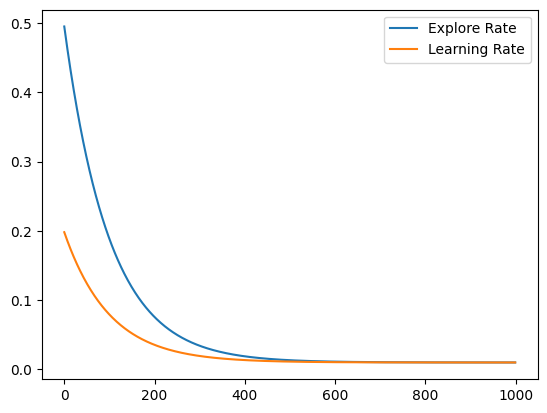

In [15]:
episodes = np.arange(1, 1001)
plt.plot(update_explore_rate(episodes, 0.01), label="Explore Rate")
plt.plot(update_learning_rate(episodes, 0.01), label="Learning Rate")
plt.legend()
plt.show()

### Task 3: Play with Hyperparameters


In [16]:
# Task 3: Play with Hyperparameters

# YOUR CODE GOES HERE: replace None with your values
GAMMA_test = 0.9
NUM_EPISODES_test = 1_000
MIN_EXPLORE_RATE_test = 0.01
MIN_LEARNING_RATE_test = 0.001
STEP_SIZE_TEST = 64

## 🐤 Now use Q learning to learn the Q table

### Task 4: Train the agent using Q-learning


The Q-value update equation, also known as the Bellman equation, is as follows:

$Q(s, a) = Q(s, a) + α * [reward + γ * max(Q(s', a')) - Q(s, a)]$


In [17]:
# Task 4: Train the agent using Q-learning
tmp_env.manual_mode = False

total_reward = 0
explore_rate = update_explore_rate(0, MIN_EXPLORE_RATE_test)
learning_rate = update_learning_rate(0, MIN_LEARNING_RATE_test)

# Tip: iterate over number of episodes
# Tip: iterate over number of steps in each Episode
# Tip: use helper functions defined above to navigate the environment
# Tip: use the Q-learning update rule equation - Bellman equation
# Tip : print variables of interest, like episode, total_reward, explore_rate

for episode in range(NUM_EPISODES_test):
    tmp_env.reset()
    state = tmp_env.get_1d_state()
    episode_reward = 0

    for step in range(STEP_SIZE_TEST):
        action = update_action(tmp_env, state, explore_rate, Q_test)
        _, reward, done, _ = tmp_env.step(action)
        next_state = tmp_env.get_1d_state()
        episode_reward += reward

        Q_test[state, action] += learning_rate * (
            reward
            + GAMMA_test * max(Q_test[next_state])
            - Q_test[state, action]
        )

        state = next_state

        if done:
            break

    if episode % 50 == 0:
        print(
            f"Episode: {episode}, Total_reward: {total_reward}, Explore rate: "
            f"{explore_rate}"
        )

    total_reward += episode_reward
    explore_rate = update_explore_rate(episode, MIN_EXPLORE_RATE_test)
    learning_rate = update_learning_rate(episode, MIN_LEARNING_RATE_test)

print(f"Final Q values: {Q_test}")

Episode: 0, Total_reward: 0, Explore rate: 0.5
Episode: 50, Total_reward: 117900, Explore rate: 0.3101869331503639
Episode: 100, Total_reward: 431100, Explore rate: 0.1920725786008024
Episode: 150, Total_reward: 783900, Explore rate: 0.12043260121432496
Episode: 200, Total_reward: 1166100, Explore rate: 0.07698075846830668
Episode: 250, Total_reward: 1563000, Explore rate: 0.05062588362183461
Episode: 300, Total_reward: 1964400, Explore rate: 0.034640843994560015
Episode: 350, Total_reward: 2373300, Explore rate: 0.024945427363896565
Episode: 400, Total_reward: 2782500, Explore rate: 0.01906485991871143
Episode: 450, Total_reward: 3197700, Explore rate: 0.015498115466698652
Episode: 500, Total_reward: 3612300, Explore rate: 0.013334775601192967
Episode: 550, Total_reward: 4027800, Explore rate: 0.012022643645385163
Episode: 600, Total_reward: 4442400, Explore rate: 0.01122679538459903
Episode: 650, Total_reward: 4858200, Explore rate: 0.010744089013953264
Episode: 700, Total_reward: 52

In [18]:
print(
    f"Total reward after training: {total_reward}, total Explore rate after "
    f"training: {explore_rate}"
)

Total reward after training: 7770300, total Explore rate after training: 0.010022469541254683


## 🐥 Let's see this in action


In [19]:
tmp_env.manual_mode = False
STEP_SIZE_TEST_test = 16

image_samples: list[AxesImage] = []

observation = tmp_env.reset()
state_0 = tmp_env.get_1d_state()
total_reward = 0

for _ in range(STEP_SIZE_TEST_test):
    img = tmp_env.render(display=False)
    image_samples.append(img)

    action = update_action(tmp_env, state_0, explore_rate, Q_test)
    obv, reward, done, info = tmp_env.step(action)
    state_0 = tmp_env.get_1d_state()
    total_reward += reward

print(f"Total_reward: {total_reward}")

Total_reward: 1200


In [20]:
# the shape of Q table (Q_test)
print(Q_test.shape)
print(f"Obs space dimensions: {tmp_env.observation_space.shape}")

(144, 4)
Obs space dimensions: (12, 12)


In [21]:
# print Q_table in "observation space" light
Q_test.argmax(axis=1).reshape(tmp_env.observation_space.shape)

array([[0, 0, 0, 2, 0, 1, 2, 0, 1, 0, 2, 3],
       [1, 2, 0, 1, 3, 0, 1, 1, 2, 2, 3, 0],
       [0, 3, 0, 2, 3, 0, 2, 2, 0, 1, 0, 2],
       [3, 1, 1, 1, 3, 3, 2, 1, 2, 1, 0, 0],
       [1, 3, 0, 1, 3, 2, 2, 2, 1, 2, 2, 1],
       [0, 1, 3, 1, 2, 3, 3, 1, 1, 1, 1, 1],
       [2, 3, 0, 3, 3, 3, 0, 1, 1, 0, 0, 0],
       [0, 3, 3, 0, 3, 3, 0, 0, 1, 1, 1, 2],
       [0, 1, 0, 0, 3, 2, 2, 0, 0, 1, 1, 1],
       [2, 3, 1, 3, 3, 2, 0, 0, 0, 1, 0, 1],
       [0, 3, 2, 2, 1, 3, 1, 0, 1, 0, 0, 1],
       [0, 3, 1, 3, 3, 3, 0, 0, 3, 0, 0, 1]])

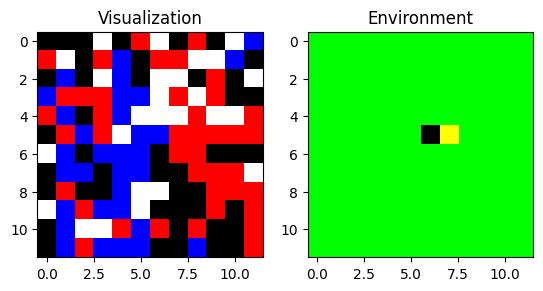

In [22]:
# visualize

q_pallete = np.array(
    [
        [0, 0, 0],  # black:0:Up
        [255, 0, 0],  # red:1:Left
        [255, 255, 255],  # white:2:Down
        [0, 0, 255],  # blue:3:Right
    ],
    dtype=np.uint8,
)

Q_table_render_arr = make_3d(
    map_2d=Q_test.argmax(axis=1).reshape(tmp_env.observation_space.shape),
    palette_array=q_pallete,
)

O_render_arr = make_3d(
    map_2d=tmp_env.observation, palette_array=tmp_env.pallete
)

plt.subplot(1, 2, 1)
plt.imshow(Q_table_render_arr)
plt.title("Visualization")
plt.subplot(1, 2, 2)
plt.imshow(O_render_arr)
plt.title("Environment")
plt.show()

MovieWriter ffmpeg unavailable; using Pillow instead.


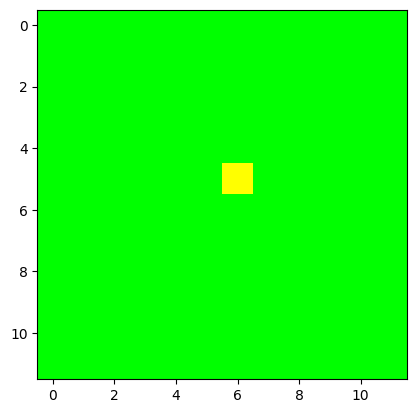

In [23]:
height, width, _ = img.shape
output_folder = get_path("output_stuff")

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

fig = plt.figure()
imgs: list[AxesImage] = []

for i in range(STEP_SIZE_TEST_test):
    im = plt.imshow(image_samples[i].reshape(height, width, 3), animated=True)
    imgs.append([im])

animate = ArtistAnimation(fig, imgs, interval=80, blit=True, repeat_delay=1000)
filename_gif = get_path(output_folder, "animation_test_1.gif")
animate.save(filename_gif)
plt.show()

### Task 5: Explain visual representation (Visualization picture on the left) after training


You can write your notes related to Task 5 here:

The visual representation of the environment after training shows which actions are the best to take in each state. The agent has learned the optimal policy for each state, which is represented by the respective color in the visualization. The model goes to the goal, and then it goes "right," then "left," and repeats this process to get as many points as possible. The agent has learned the best actions to take in each state to maximize its rewards.


In [24]:
tmp_env.close()

image has more than 3 channels, only first 3 channels are used there are (12, 12, 4) channels


# 2️⃣ Assignment 2: Trondheim treasure hunt!


# 🐔 You are ready for the Trondheim challenge now 💪

- Task 1: Initialize Q table
- Task 2: Write necessary helper functions for Q-learning
- Task 3: Play with Hyperparameters
- Task 4: Train the agent using Q-learning

## **Important Note**:

For Task 2, Task 3 and Task 4, you can (re)use the same code as in the Assignment 1.
**These are mentioned here as the elements of the pipeline.**

Most of the code from Assigment 1 is reusable, we are just using it with different environment here.


In [25]:
env_config = {
    "env_image_path": get_path(input_folder, "image_TRD_2.png"),
    "dead_allowed": False,
    "remove_after_location_found": True,
    "start_random": False,
    "number_removable_locations": 1,
}

if not os.path.exists(env_config["env_image_path"]):
    raise FileNotFoundError(
        f"The image path {env_config['env_image_path']} does not exist."
    )

tmp_env = TrondheimEnv(conf=env_config)
print(f"Environment successfully created")

Environment successfully created


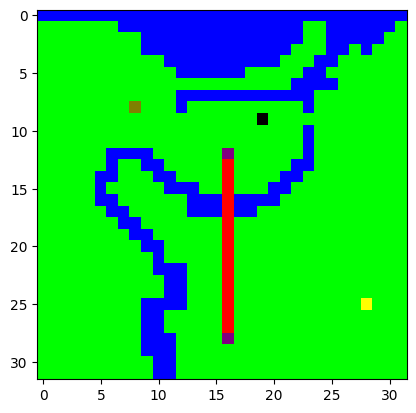

array([[[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255]],

       [[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [  0, 255,   0]],

       [[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [  0,   0, 255],
        [  0, 255,   0],
        [  0, 255,   0]],

       ...,

       [[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]],

       [[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]],

       [[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

In [26]:
tmp_env.reset()
tmp_env.render()

Next step towards:
Green Land class area
0


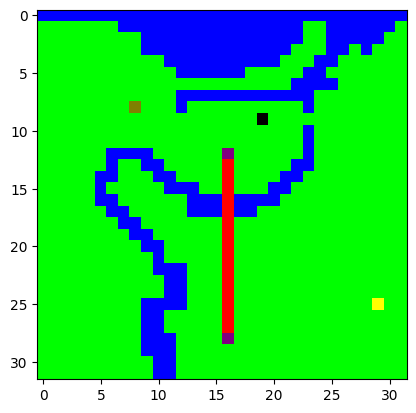

array([[[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255]],

       [[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [  0, 255,   0]],

       [[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [  0,   0, 255],
        [  0, 255,   0],
        [  0, 255,   0]],

       ...,

       [[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]],

       [[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]],

       [[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

In [27]:
my_action = "right"

obs, rew, term, info = tmp_env.step(action_dict[my_action])
print(rew)
tmp_env.render()

### Task 1: Initialize Q table


In [28]:
# Task 1: Initialize Q table
# Tip: pay attention to the dimensions of Q table
# Tip: how many states the table have, how many actions
# Extra tip:
"""number of states is different here in comparison with first example:
we have 2 subcases for this environment:
when Location is there and when it is removed/destroyed"""

print(f"Observation space dimensions: {tmp_env.observation_space.shape}")
print(f"Number of possible actions: {tmp_env.action_space.n}")

state = 2 * np.prod(tmp_env.observation_space.shape)
action = tmp_env.action_space.n

Q_test = rng.uniform(size=(state, action))
print(Q_test.shape)

Observation space dimensions: (32, 32)
Number of possible actions: 4
(2048, 4)


### Task 2: Write necessary helper functions for Q-learning


In [29]:
# Task 2: Write necessary helper functions for Q-learning
# Tip: just use the same helper functions you already implemented above

### Task 3: Play with Hyperparameters


In [30]:
# Task 3: Play with Hyperparameters
# Tip - you can also use the same parameters as for the toy example above

GAMMA_test = 0.9
NUM_EPISODES_test = 1_000
MIN_EXPLORE_RATE_test = 0.01
MIN_LEARNING_RATE_test = 0.001
STEP_SIZE_TEST = 1024
# Depending on your parameters for the toy environment, using the same
# parameters here could work fine
# If they are not working, you may want to set them to different values here

## Now use Q-learning to learn the Q table

### Task 4: Train the agent using Q-learning


In [31]:
# Task 4: Train the agent using Q-learning
# Tip - you can use the same code (or function) as used for simple environment (Assignment 1 Task 4)
tmp_env.manual_mode = False
total_reward = 0

for episode in range(NUM_EPISODES_test):
    tmp_env.reset()
    state = tmp_env.get_1d_state()
    episode_reward = 0
    explore_rate = update_explore_rate(episode, MIN_EXPLORE_RATE_test)
    learning_rate = update_learning_rate(episode, MIN_LEARNING_RATE_test)

    for step in range(STEP_SIZE_TEST):
        action = update_action(tmp_env, state, explore_rate, Q_test)
        _, reward, done, _ = tmp_env.step(action)
        next_state = tmp_env.get_1d_state()
        episode_reward += reward

        Q_test[state, action] += learning_rate * (
            reward
            + GAMMA_test * max(Q_test[next_state])
            - Q_test[state, action]
        )

        state = next_state

        if done:
            break

    total_reward += episode_reward

    if episode % 50 == 0:
        print(
            f"Episode: {episode}, Total_reward: {total_reward}, Explore rate: "
            f"{explore_rate}"
        )

print(f"Final Q values: {Q_test}")

Episode: 0, Total_reward: 9000, Explore rate: 0.5
Episode: 50, Total_reward: 1545400, Explore rate: 0.3072000232591904
Episode: 100, Total_reward: 5135200, Explore rate: 0.19026092617400675
Episode: 150, Total_reward: 9635200, Explore rate: 0.1193337784727306
Episode: 200, Total_reward: 14617600, Explore rate: 0.07631428878594022
Episode: 250, Total_reward: 19771800, Explore rate: 0.05022164932571041
Episode: 300, Total_reward: 25023400, Explore rate: 0.03439566350025333
Episode: 350, Total_reward: 30317600, Explore rate: 0.024796717876936065
Episode: 400, Total_reward: 35640800, Explore rate: 0.01897466305547975
Episode: 450, Total_reward: 40984200, Explore rate: 0.01544340830373873
Episode: 500, Total_reward: 46341000, Explore rate: 0.013301594029551878
Episode: 550, Total_reward: 51693200, Explore rate: 0.012002518004847394
Episode: 600, Total_reward: 57058600, Explore rate: 0.011214588566566515
Episode: 650, Total_reward: 62424400, Explore rate: 0.010736685204559011
Episode: 700, T

In [32]:
print(
    f"Total reward after training: {total_reward}, Explore rate after "
    f"training: {explore_rate}"
)

Total reward after training: 99917200, Explore rate after training: 0.010022469541254683


## Let's see one episode


In [33]:
tmp_env.manual_mode = False
STEP_SIZE_TEST_test = 44

image_samples: list[NDArray[Any]] = []

observation = tmp_env.reset()
state_0 = tmp_env.get_1d_state()
total_reward = 0

for _ in range(STEP_SIZE_TEST_test):
    img = tmp_env.render(display=False)
    image_samples.append(img)

    action = update_action(tmp_env, state_0, explore_rate, Q=Q_test)
    obv, reward, done, info = tmp_env.step(action)
    state_0 = tmp_env.get_1d_state()
    total_reward += reward

print(f"Total_reward: {total_reward}")

Total_reward: 10000


### Simple animation of agent movement in one episode


MovieWriter ffmpeg unavailable; using Pillow instead.


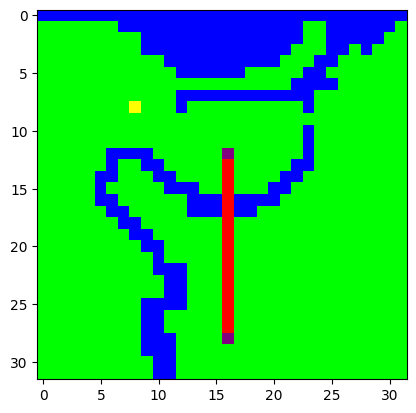

In [34]:
height, width, _ = img.shape

fig = plt.figure()
imgs: list[AxesImage] = []

for i in range(STEP_SIZE_TEST_test):
    im = plt.imshow(image_samples[i].reshape(height, width, 3), animated=True)
    imgs.append([im])

animate = ArtistAnimation(fig, imgs, interval=80, blit=True, repeat_delay=1000)
filename_gif = get_path(output_folder, "animation_test_2.gif")
animate.save(filename_gif)
plt.show()

In [35]:
tmp_env.close()

image has more than 3 channels, only first 3 channels are used there are (32, 32, 4) channels
